In [1]:
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')
    COLAB = True
except:
    COLAB = False

!pip install gymnasium==0.29.1 vizdoom==1.2.4 wandb==0.19.1

In [2]:
import json
import math
import random
import sys
import os
import time
from collections import deque
from typing import Dict, Type, Any, Tuple, NamedTuple, Optional, Union, Generator, List

import gymnasium as gym
import gymnasium.spaces as spaces
from gymnasium.vector import AsyncVectorEnv, SyncVectorEnv
from gymnasium.wrappers import ResizeObservation, GrayScaleObservation, RecordEpisodeStatistics, TransformReward, \
    FrameStack
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions import Categorical
import vizdoom
from vizdoom import gymnasium_wrapper

WANDB_IS_AVAILABLE = False

os.environ["WANDB_API_KEY"] = "e97ffa4c776cbfb2c0fc0c8b5c97e875139c1d42"

# Градиент стратегии: REINFORCE

Обозначения:
- $s$ - состояние, $r$ - вознаграждение, $a$ - действие
- Условное распределение действий $\pi(a | s)$ - стратегия агента
- $\tau$ - траектория: $(s_0, r_0, a_0), \dots, (s_T, r_T, a_T)$
- Отдача $G(\tau) = \sum_{t = 0} ^ T r_t \gamma ^ t$
- $G_t = r_t + r_{t + 1} \gamma + \dots + r_{T} \gamma ^ {T - t}$
- Функция полезности состояний: $V(s_{t}) = \mathbb{E}[G_t]$
- Функция полезности действий: $Q(s_t, a_t) = \mathbb{E}[r_t + \gamma V(s_{t + 1}) | a_t]$

В некоторых задачах для нахождения удовлетворительной стратегии необязательно в точности знать структуру всей среды. Например, в задаче поднятия кубика робототехнической рукой вместо точной аппроксимации полезности $Q(s,a)$ достаточно знать, что выгоднее: двигаться вправо, если кубик справа, и влево в ином случае. С этим же наблюдением связано и предположение, что задача поиска удовлетворительной стратегии проще, нежели задача точной оценки функции полезности.

В данном семинаре познакомимся с простейшим методом прямой оптимизации стратегии REINFORCE, в котором параметры, задающие вероятностную стратегию, изменяются в соответствии с градиентом математического ожидания отдач:

$$J(\theta)= \mathbb{E}[G(\tau)],$$

$$\theta \leftarrow \theta +\alpha \nabla_{\theta} J(\theta),$$

В первом выражении математическое ожидание берется по распределениям начальных состояний, вероятностным функциям переходов и вознаграждений среды, а также по вероятностной стратегии агента $\pi_\theta$. Благодаря теореме о существовании стационарного распределения марковской цепи, это выражение может быть переписано через стационарное распределение $d^\pi$ посещения состояний в среде:

$$J(\theta)= \mathbb{E}_{s \sim d^\pi}[V^{\pi}(s)] = \mathbb{E}_{s \sim d^\pi, a \sim \pi(s)} [Q^{\pi}(s, a)] =: \mathbb{E}_\pi [Q^{\pi}(s, a)].$$

Метод REINFORCE также использует теорему о градиенте стратегии, на основе которой построено целое семейство алгоритмов прямой оптимизации стратегии и актор-критиков. Теорема о градиенте стратегии связывает градиент целевой функции $J$ и градиент самой стратегии:

$$\nabla_\theta J(\theta) = \mathbb{E}_\pi [Q^\pi(s, a) \nabla_\theta \ln \pi_\theta(a \vert s)]$$

Для оценки полезности действий $Q^\pi(s, a)$ REINFORCE использует несмещенную Монте-Карло оценку на основе полученных в среде отдач $G_t$ (за некоторое фиксированное число эпизодов в среде). С учетом этого обновление весов осуществляется по правилу:

$$\nabla_\theta J(\theta) = \mathbb{E}_\pi [G_t \nabla_\theta \ln \pi_\theta(a_t \vert s_t)]$$

Более подробное (но все равно короткое) описание градиента стратегии, и в частности REINFORCE, можно посмотреть в [блоге Lilian Weng из OpenAI](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/#policy-gradient), либо полноценно разобраться в соответствующей секции классического учебника Саттона и Барто.

### Environment: Vizdoom
Среда для экспериментов: **Vizdoom**. Задача: **VizdoomCorridor-v0**.

Карта представляет собой коридор со стреляющими противниками по обеим сторонам. Зелёная броня размещена на противоположном конце коридора. Цель агента — добраться до предмета. Награда пропорциональна (отрицательна или положительна) изменению расстояния между игроком и жилетом.
- Вознаграждение: +dX за приближение к броне, -dX за отдаление от брони, -100 за смерть.
- Агенту доступны 7 действий: движение вперед/назад/влево/вправо, поворот влево/вправо, стрельба.
- Ограничение по времени: 2100 шагов

Для ускорения обучения агента рассматриваем самый простой уровень сложности `doom_skill = 1`.

/home/lad1chka/HSE/RL/practices/venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
/home/lad1chka/HSE/RL/practices/venv/lib/python3.12/site-packages/vizdoom/gymnasium_wrapper/base_gymnasium_env.py:84: UserWarning: Detected screen format CRCGCB. Only RGB24 and GRAY8 are supported in the Gymnasium wrapper. Forcing RGB24.
  warnings.warn(


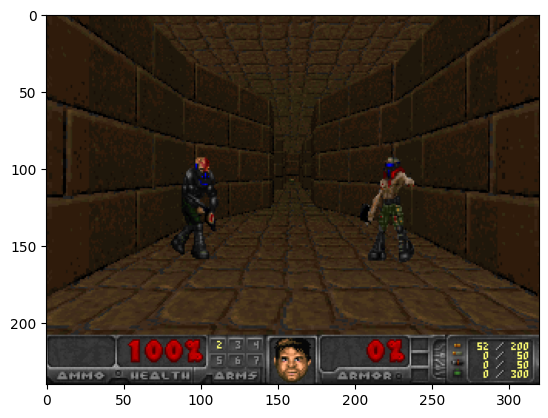

{'scenario_file': '/home/lad1chka/HSE/RL/practices/prac5/deadly_corridor_doom-skill-1.cfg'}


In [3]:
def create_vizdoom_config(verbose=False):
    # Создаёт файл сценария VizdoomCorridor с уровнем сложности doom_skill = 1

    deadly_corridor_doom_skill_1 = """
    # Lines starting with # are treated as comments (or with whitespaces+#).
    # It doesn't matter if you use capital letters or not.
    # It doesn't matter if you use underscore or camel notation for keys, e.g. episode_timeout is the same as episodeTimeout.
    """
    deadly_corridor_doom_skill_1 += f"\ndoom_scenario_path = {os.path.relpath(os.path.dirname(vizdoom.__file__))}/scenarios/deadly_corridor.wad\n"
    deadly_corridor_doom_skill_1 += """
    # Skill 5 is recommended for the scenario to be a challenge.
    doom_skill = 1

    # Rewards
    death_penalty = 100
    #living_reward = 0

    # Rendering options
    screen_resolution = RES_320X240
    screen_format = CRCGCB
    render_hud = true
    render_crosshair = false
    render_weapon = true
    render_decals = false
    render_particles = false
    window_visible = true

    episode_timeout = 2100

    # Available buttons
    available_buttons =
      {
        MOVE_LEFT
        MOVE_RIGHT
        ATTACK
        MOVE_FORWARD
        MOVE_BACKWARD
        TURN_LEFT
        TURN_RIGHT
      }

    # Game variables that will be in the state
    available_game_variables = { HEALTH }

    mode = PLAYER
    """

    config_file_name = f'deadly_corridor_doom-skill-1.cfg'
    with open(config_file_name, 'w') as file_obj:
        print(deadly_corridor_doom_skill_1, file=file_obj)

    if verbose:
        print(deadly_corridor_doom_skill_1)

    return os.path.realpath(config_file_name)


def source_env_info():
    config_file_path = create_vizdoom_config()
    env = gym.make('VizdoomCorridor-v0', **{'scenario_file': config_file_path})
    obs, _ = env.reset()
    plt.imshow(obs['screen'])
    plt.show()
    print(env.env.env.spec.kwargs)

source_env_info()

### Wrappers

Наблюдение - стек из 3х последовательных изображений 84х84 в оттенках серого, shape: (3, 84, 84)


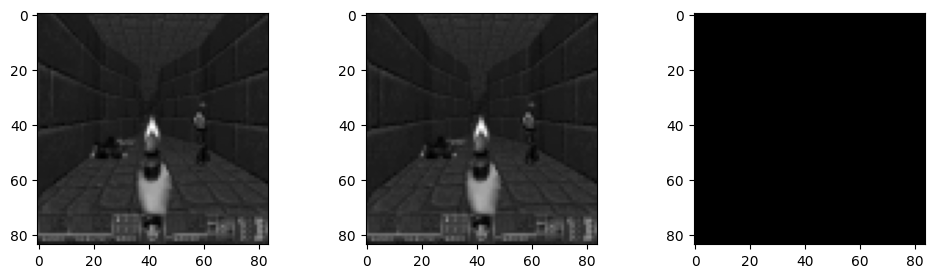

info на последнем шаге содержит статистику эпизода: r - суммарное вознаграждение, l - длина эпизода, t - продолжительность эпизода в секундах
 {'episode': {'r': array([-101.36774], dtype=float32), 'l': array([992], dtype=int32), 't': array([1.421875], dtype=float32)}}


In [4]:
class ImageExtractorWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = env.observation_space['screen']

    def observation(self, observation: Dict) -> np.ndarray:
        return observation['screen']


def make_env():
    config_file_path = create_vizdoom_config()
    env = gym.make('VizdoomCorridor-v0', **{'scenario_file': config_file_path})
    env = ImageExtractorWrapper(env)
    env = GrayScaleObservation(env)
    env = ResizeObservation(env, shape=84)
    env = FrameStack(env, num_stack=3)
    env = RecordEpisodeStatistics(env)
    env = TransformReward(env, f=lambda reward: reward / 100.)

    return env


def wrapped_env_info():
    config_file_path = create_vizdoom_config()
    env = make_env()
    env.reset()
    terminated = False
    while not terminated:
        obs, reward, terminated, truncated, info = env.step(env.action_space.sample())

    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    for ax, frame in zip(axes, obs):
        ax.imshow(frame, cmap='gray')

    print('Наблюдение - стек из 3х последовательных изображений 84х84 в оттенках серого, shape:', obs.shape)
    plt.show()
    print('info на последнем шаге содержит статистику эпизода: r - суммарное вознаграждение, l - длина эпизода, t - продолжительность эпизода в секундах\n', info)

DEMO_WRAPPED_ENV = True
if DEMO_WRAPPED_ENV:
    wrapped_env_info()

### Misc

In [5]:
def set_seed_everywhere(seed: int, using_cuda: bool = False) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if using_cuda:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 1 REINFORCE

### Policy
Основные компоненты ReinforcePolicy:
- `features_extractor` - свёрточный энкодер, кодирующий изображения в латентный вектор
- `action_net` - полносвязный слой, который выдаёт логиты действий для предсказания вероятностей

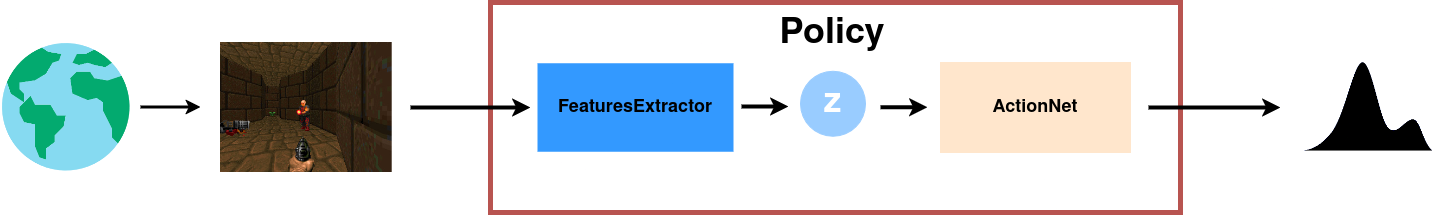

In [6]:
class Encoder(nn.Module):
    def __init__(
            self,
            observation_space: gym.Space,
            features_dim: int = 512,
    ) -> None:
        super().__init__()
        self.features_dim = features_dim
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))


class ReinforcePolicy(nn.Module):
    def __init__(self, observation_space: gym.Space, action_space: gym.Space, lr: float,
                 optimizer_class: Type[torch.optim.Optimizer] = torch.optim.RMSprop,
                 optimizer_kwargs: Dict[str, Any] = {'eps': 1e-5},):
        super().__init__()
        self.observation_space = observation_space
        self.action_space = action_space
        self.lr = lr
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = dict(optimizer_kwargs)
        self.features_extractor = self.make_features_extractor()
        self.action_net = nn.Linear(self.features_extractor.features_dim, self.action_space.n)
        self.optimizer = self.optimizer_class(self.parameters(), lr=self.lr, **self.optimizer_kwargs)

    def make_features_extractor(self):
        return Encoder(self.observation_space)

    def extract_features(self, obs: torch.Tensor) -> torch.Tensor:
        obs = obs.float() / 255.
        features = self.features_extractor(obs)

        return features

    def forward(self, obs: torch.Tensor, deterministic: bool = False) -> Dict[str, torch.Tensor]:
        features = self.extract_features(obs)

        action_logits = self.action_net(features)
        distribution = Categorical(logits=action_logits)
        actions = distribution.mode() if deterministic else distribution.sample()
        actions = actions.reshape((-1, *self.action_space.shape))

        return {'features': features, 'action': actions}

    def evaluate_actions(self, obs: torch.Tensor, actions_taken: torch.Tensor) -> Dict[str, torch.Tensor]:
        features = self.extract_features(obs)
        action_logits = self.action_net(features)
        distribution = Categorical(logits=action_logits)
        log_prob = distribution.log_prob(actions_taken)
        entropy = distribution.entropy()

        return {'features': features, 'log_prob': log_prob, 'entropy': entropy}

    def set_training_mode(self, mode: bool) -> None:
        self.train(mode)

### Buffer
В буфере хранятся траектории, собранные агентом. Также в буфере производится вычисление частичных отдач по траекториям.

In [7]:
class BufferSamples(NamedTuple):
    observations: torch.Tensor
    actions: torch.Tensor
    returns: torch.Tensor


class Buffer:
    def __init__(
            self,
            gamma: float = 0.99,
            device: Union[torch.device, str] = "cpu",
    ):
        self.device = torch.device(device)
        self.gamma = gamma
        self.observations = None
        self.actions = None
        self.rewards = None
        self.returns = None

    def reset(self) -> None:
        self.observations = []
        self.actions = []
        self.rewards = []
        self.returns = None

    def size(self) -> int:
        return len(self.actions)

    def add(
            self,
            obs: np.ndarray,
            action: int,
            reward: float,
    ) -> None:
        self.observations.append(obs)
        self.actions.append(action)
        self.rewards.append(reward)

    def to_torch(self, array: np.ndarray) -> torch.Tensor:
        return torch.tensor(array, device=self.device)

    def _get_samples(
            self,
            batch_inds: np.ndarray,
    ) -> BufferSamples:
        observations = self.to_torch(self.observations[batch_inds])
        actions = self.to_torch(self.actions[batch_inds])
        returns = self.to_torch(self.returns[batch_inds])

        return BufferSamples(observations=observations, actions=actions, returns=returns)

    def get(self) -> BufferSamples:
        buffer_size = self.size()
        indices = np.random.permutation(buffer_size)
        self.observations = np.asarray(self.observations)
        self.actions = np.asarray(self.actions)
        self.returns = np.asarray(self.returns, dtype=np.float32)

        return self._get_samples(indices)

    def compute_returns(self) -> None:
        returns = [None] * len(self.rewards)
        reward_to_go = 0
        for step in reversed(range(len(self.rewards))):
            reward_to_go = self.rewards[step] + self.gamma * reward_to_go
            returns[step] = reward_to_go

        self.returns = returns

### Обучение стратегии по методу REINFORCE
- Метод `learn`: реализует основной цикл RL-обучения: чередование фазы сбора данных (траекторий) агентом в среде - `collect_rollouts` и фазы обучения агента - `train`.
- Метод `collect_rollouts`: агент выполняет действия в среде согласно текущей стратегии, собирая триплеты **<observation, action, reward>** в буфер
- Метод `train`: обучение на собранных данных. Функция потерь состоит из двух слагаемых: градиент стратегии и энтропийная регуляризация. Энтропийная регуляризация делает стратегию более стохастичной, т.е. более устойчивой к шуму, помогает исследовать среду, предотвращает сходимость к субоптимальному решению (особенно в средах с дискретными действиями)

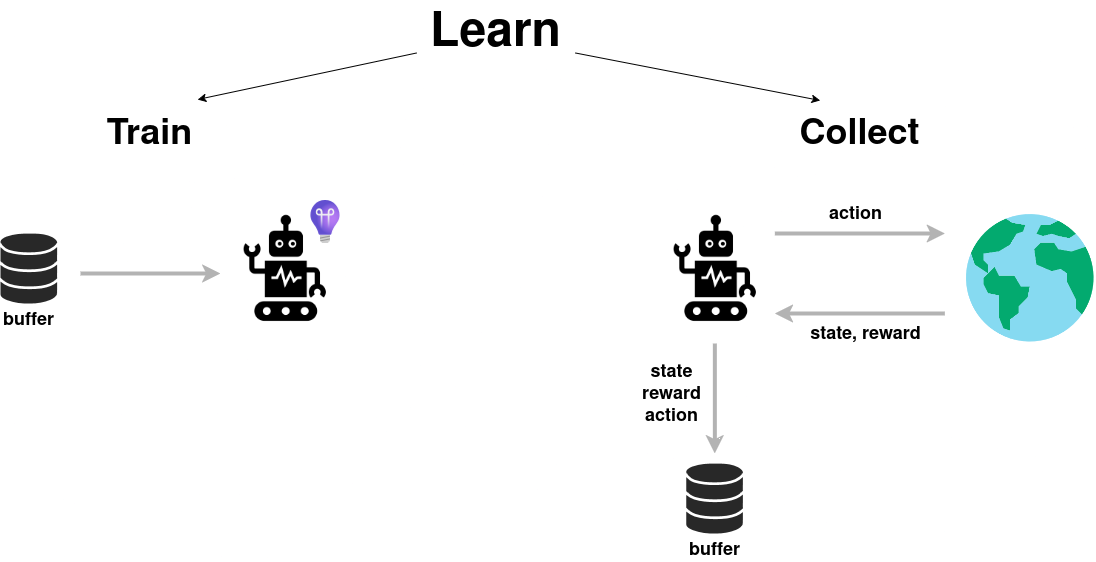

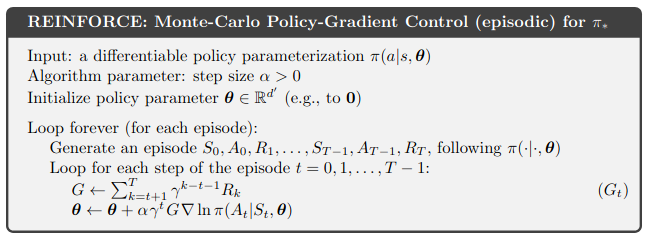

In [8]:
class Reinforce:
    def __init__(
            self,
            env: gym.Env,
            learning_rate: float = 2.5e-4,
            gamma: float = 0.99,
            ent_coef: float = 0.001,
            max_grad_norm: float = 0.5,
            stats_window_size: int = 10,
            policy_class: Type[ReinforcePolicy] = ReinforcePolicy,
            policy_kwargs: Optional[Dict[str, Any]] = None,
            buffer_class: Type[Buffer] = Buffer,
            buffer_kwargs: Optional[Dict[str, Any]] = None,
            seed: Optional[int] = None,
            device: Union[torch.device, str] = "cuda",
    ):
        self.device = device if isinstance(device, torch.device) else torch.device(device)
        print(f"Using {self.device} device")

        self.policy_kwargs = {} if policy_kwargs is None else policy_kwargs

        self.num_timesteps = 0
        self._num_timesteps_at_start = 0
        self._episode_num = 0
        self.seed = seed
        self.start_time = 0.0
        self.learning_rate = learning_rate
        self._last_obs = None
        self._stats_window_size = stats_window_size
        self.ep_info_buffer = deque(maxlen=self._stats_window_size)
        self._n_updates = 0

        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.env = env

        self.n_steps = None
        self.gamma = gamma
        self.ent_coef = ent_coef
        self.max_grad_norm = max_grad_norm
        self.log_dict = {}

        self.set_random_seed(self.seed)
        self.buffer_class = buffer_class
        self.buffer_kwargs = {} if buffer_kwargs is None else buffer_kwargs
        self.buffer = self.buffer_class(
            device=self.device,
            gamma=self.gamma,
            **self.buffer_kwargs,
        )
        self.policy_class = policy_class
        self.policy = self.policy_class(
            self.observation_space, self.action_space, self.learning_rate, **self.policy_kwargs
        )
        self.policy = self.policy.to(self.device)

    def _update_info_buffer(self, info: Dict[str, Any]) -> None:
        # Collect statistics
        assert self.ep_info_buffer is not None

        ep_info = info.get("episode")
        if ep_info is not None:
            self.ep_info_buffer.append(ep_info)

    def set_random_seed(self, seed: Optional[int] = None) -> None:
        if seed is None:
            return
        set_seed_everywhere(seed, using_cuda=self.device.type == torch.device("cuda").type)
        self.action_space.seed(seed)
        self.observation_space.seed(seed)

    def collect_rollouts(
            self,
            env,
            buffer: Buffer,
    ):
        self.policy.set_training_mode(False)
        self._last_obs, _ = self.env.reset()
        self._last_obs = np.array(self._last_obs)
        assert self._last_obs is not None, "No previous observation was provided"

        buffer.reset()
        terminated = False
        while not terminated:
            with torch.no_grad():
                obs_tensor = torch.as_tensor(self._last_obs, device=self.device)
                action = self.policy(obs_tensor.unsqueeze(0))['action']
            action = action.item()
            new_obs, reward, terminated, truncated, info = env.step(action)
            assert not truncated, 'Episode truncation must be off as we want to use Monte Carlo estimation'

            self.num_timesteps += 1
            self._episode_num += int(terminated)
            buffer.add(
                self._last_obs,
                action,
                reward,
            )

            self._last_obs = np.array(new_obs)
            self._update_info_buffer(info)

        buffer.compute_returns()

    def train(self) -> None:
        self.policy.set_training_mode(True)

        rollout_data = self.buffer.get()
        actions = rollout_data.actions.long()
        policy_output = self.policy.evaluate_actions(rollout_data.observations, actions)
        log_prob = policy_output['log_prob']
        entropy = policy_output['entropy']
        returns = rollout_data.returns

        # Policy gradient loss
        policy_loss = -(returns * log_prob).mean()

        # Entropy loss
        entropy = torch.mean(entropy)
        entropy_loss = -self.ent_coef * entropy

        loss = policy_loss + entropy_loss

        # Optimization step
        self.policy.optimizer.zero_grad()
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
        self.policy.optimizer.step()

        self._n_updates += 1

        self.log_dict = dict([
            ("train/entropy_loss", entropy_loss.item()), ("train/entropy", entropy.item()),
            ("train/policy_gradient_loss", policy_loss.item()), ("train/loss", loss.item()),
            ("train/grad_norm", grad_norm.item()), ("train/n_updates", self._n_updates)
        ])

    def get_current_mean_return(self) -> float:
        if len(self.ep_info_buffer) == 0:
            return -math.inf

        return np.mean(np.concatenate([ep_info["r"] for ep_info in self.ep_info_buffer])).item()

    def _dump_logs(self, iteration: int) -> None:
        assert self.ep_info_buffer is not None

        time_elapsed = max((time.time_ns() - self.start_time) / 1e9, sys.float_info.epsilon)
        fps = int((self.num_timesteps - self._num_timesteps_at_start) / time_elapsed)
        self.log_dict["time/iterations"] = iteration
        if len(self.ep_info_buffer) > 0 and len(self.ep_info_buffer[0]) > 0:
            self.log_dict["rollout/ep_rew_mean"] = self.get_current_mean_return()
            self.log_dict["rollout/ep_len_mean"] = np.mean(
                np.concatenate([ep_info["l"] for ep_info in self.ep_info_buffer])).item()

        self.log_dict["time/fps"] = fps
        self.log_dict["time/time_elapsed"] = int(time_elapsed)
        self.log_dict["global_step"] = self.num_timesteps
        self.log_dict["num_episodes"] = self._episode_num
        print(json.dumps(self.log_dict, sort_keys=True, indent=4))

        if WANDB_IS_AVAILABLE and wandb.run is not None:
            wandb.log(self.log_dict)

    def learn(
            self,
            max_timesteps: int,
            expected_return: float,
            log_interval: int = 1000,
            save_checkpoint_path: str = None,
            save_checkpoint_interval: int = 5000,
    ) -> None:
        assert self.env is not None

        self.start_time = time.time_ns()
        self.num_timesteps = 0
        self._episode_num = 0
        self._num_timesteps_at_start = 0
        log_interval = log_interval or math.inf
        if save_checkpoint_path is None or save_checkpoint_interval is None or not COLAB:
            save_checkpoint_interval = math.inf

        next_log_step = self.num_timesteps + log_interval
        next_save_step = self.num_timesteps + save_checkpoint_interval

        if self._last_obs is None:
            self._last_obs, _ = self.env.reset(seed=self.seed)

        iteration = 0
        while True:
            if self.get_current_mean_return() >= expected_return:
                print('Решено!')
                break

            if self.num_timesteps >= max_timesteps:
                print(f'Задача не решена за {max_timesteps} шагов')
                break

            self.collect_rollouts(self.env, self.buffer, )
            iteration += 1

            if self.num_timesteps >= next_log_step:
                assert self.ep_info_buffer is not None
                self._dump_logs(iteration)
                next_log_step += log_interval

            if self.num_timesteps >= next_save_step:
                next_save_step += save_checkpoint_interval
                checkpoint = {'policy': self.policy.state_dict(), 'optimizer': self.policy.optimizer.state_dict(),
                              'num_timesteps': self.num_timesteps, 'episode_num': self._episode_num,
                              'ep_info_buffer': self.ep_info_buffer}
                os.makedirs(save_checkpoint_path, exist_ok=True)
                torch.save(checkpoint, os.path.join(save_checkpoint_path, 'checkpoint.pt'))

            self.train()

In [9]:
def run_algorithm(algorithm_class, algorithm_kwargs, use_wandb, wandb_kwargs, learn_kwargs):
    env = make_env()
    model = algorithm_class(env, **algorithm_kwargs)
    if use_wandb:
        config = {}
        config.update(algorithm_kwargs)
        config.update(learn_kwargs)
        config.update(wandb_kwargs.get('config', {}))
        wandb_kwargs['config'] = config
        if wandb.run is not None:
            wandb.finish()

        wandb.init(**wandb_kwargs)

    model.learn(**learn_kwargs)
    if use_wandb:
        wandb.finish()

In [10]:
run_algorithm(
    algorithm_class=Reinforce,
    algorithm_kwargs=dict(seed=0, device="cpu"),
    use_wandb=False,  # Отключаем wandb
    wandb_kwargs=dict(project='seminar_actor-critic', monitor_gym=True, name='reinforce'),
    learn_kwargs=dict(max_timesteps=50000, log_interval=1000, expected_return=2000, save_checkpoint_interval=1000,
                      save_checkpoint_path='/content/drive/My Drive/seminar_actor-critic/reinforce',)
)

Using cpu device


/tmp/ipykernel_84771/3336005168.py:79: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  self._last_obs = np.array(self._last_obs)
/tmp/ipykernel_84771/3336005168.py:100: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  self._last_obs = np.array(new_obs)


{
    "global_step": 1240,
    "num_episodes": 3,
    "rollout/ep_len_mean": 413.3333333333333,
    "rollout/ep_rew_mean": -83.91937255859375,
    "time/fps": 110,
    "time/iterations": 3,
    "time/time_elapsed": 11,
    "train/entropy": 2.0787887573242188,
    "train/entropy_loss": -0.002078788820654154,
    "train/grad_norm": 0.016709856688976288,
    "train/loss": -0.44617414474487305,
    "train/n_updates": 2,
    "train/policy_gradient_loss": -0.44409534335136414
}
{
    "global_step": 2060,
    "num_episodes": 5,
    "rollout/ep_len_mean": 412.0,
    "rollout/ep_rew_mean": -78.78369140625,
    "time/fps": 111,
    "time/iterations": 5,
    "time/time_elapsed": 18,
    "train/entropy": 2.078404664993286,
    "train/entropy_loss": -0.002078404650092125,
    "train/grad_norm": 0.01469994243234396,
    "train/loss": -0.20474717020988464,
    "train/n_updates": 4,
    "train/policy_gradient_loss": -0.20266877114772797
}
{
    "global_step": 3311,
    "num_episodes": 8,
    "rollout/

# 2 REINFORCE с базовым уровнем
Градиент стратагии зависит от величины отдачи. Однако отдача может быть очень шумной оценкой $Q ^ {\pi} (s, a)$, особенно в средах с отложенными или редкими вознаграждениями. Этот шум приводит к высокой дисперсии в оценках градиента, что влечёт за собой сильные изменения стратегии. При этом обучение становится нестабильным, а сходимость медленной. Одним из способов снижения дисперсии является использование базового уровня $b(s)$. Базовый уровень $b(s)$ не зависит от действий, поэтому вычитание из оценки $Q ^ {\pi} (s, a)$ не приводит к смещению оценки градиента.

$$\nabla_\theta J(\theta) = \mathbb{E}_\pi [(G_t - b(s)) \nabla_\theta \ln \pi_\theta(a_t \vert s_t)]$$

## 2.1 REINFORCE с необучаемым базовым уровнем (средняя отдача)
В некоторых случаях в качестве базового уровня достаточно использовать среднюю отдачу за предыдущие эпизоды. Даже такая простая эвристика может помочь стабилизировать процесс обучения на ранних этапах.

(3 балла)

In [11]:
# AverageReturnBuffer хранит статистику - среднюю отдачу по всем состояниям и эпизодам за время обучения
class AverageReturnBuffer(Buffer):
    def __init__(self, gamma: float = 0.99, device: Union[torch.device, str] = "cpu"):
        super().__init__(gamma, device)
        self.episode_returns = []

    def get_average_return(self):
        if len(self.episode_returns) == 0:
            return 0.0
        return float(np.mean(self.episode_returns))

    def compute_returns(self) -> None:
        rewards = np.array(self.rewards)
        returns = np.zeros_like(rewards, dtype=np.float32)
        G = 0
        for t in reversed(range(len(rewards))):
            G = rewards[t] + self.gamma * G
            returns[t] = G
        self.returns = returns
        if len(rewards) > 0:
            self.episode_returns.append(returns[0])

(1 балл)

In [12]:
class AverageReturnBaselineReinforce(Reinforce):
    def __init__(self, env: gym.Env, learning_rate: float = 2.5e-4, gamma: float = 0.99, ent_coef: float = 0.001,
                 max_grad_norm: float = 0.5, stats_window_size: int = 10, policy_class: Type[ReinforcePolicy] = ReinforcePolicy,
                 policy_kwargs: Optional[Dict[str, Any]] = None, buffer_class: Type[AverageReturnBuffer] = AverageReturnBuffer,
                 buffer_kwargs: Optional[Dict[str, Any]] = None, seed: Optional[int] = None,
                 device: Union[torch.device, str] = "cuda"):
        super().__init__(env, learning_rate, gamma, ent_coef, max_grad_norm, stats_window_size, policy_class, policy_kwargs,
                         buffer_class, buffer_kwargs, seed, device)

    def train(self) -> None:
        self.policy.set_training_mode(True)

        rollout_data = self.buffer.get()
        actions = rollout_data.actions.long()
        policy_output = self.policy.evaluate_actions(rollout_data.observations, actions)
        log_prob = policy_output['log_prob']
        entropy = policy_output['entropy']

        # Получаем среднюю отдачу
        baseline = self.buffer.get_average_return()

        # Посчитать отдачи с учётом базового уровня
        returns = rollout_data.returns - baseline

        # Policy gradient loss
        policy_loss = -(returns * log_prob).mean()

        # Entropy loss
        entropy = torch.mean(entropy)
        entropy_loss = -self.ent_coef * entropy

        loss = policy_loss + entropy_loss

        # Optimization step
        self.policy.optimizer.zero_grad()
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
        self.policy.optimizer.step()

        self._n_updates += 1

        self.log_dict = dict([
            ("train/entropy_loss", entropy_loss.item()), ("train/entropy", entropy.item()),
            ("train/policy_gradient_loss", policy_loss.item()), ("train/loss", loss.item()),
            ("train/grad_norm", grad_norm.item()), ("train/n_updates", self._n_updates),
            ("train/baseline", float(baseline))
        ])

In [13]:
run_algorithm(
    algorithm_class=AverageReturnBaselineReinforce,
    algorithm_kwargs=dict(seed=0, device="cpu"),
    use_wandb=False,
    wandb_kwargs=dict(project='seminar_actor-critic', monitor_gym=True, name='reinforce_simple-baseline'),
    learn_kwargs=dict(max_timesteps=50000, log_interval=1000, expected_return=2000, save_checkpoint_interval=1000,
                    save_checkpoint_path='/content/drive/My Drive/seminar_actor-critic/reinforce_simple-baseline')
)

/home/lad1chka/HSE/RL/practices/venv/lib/python3.12/site-packages/vizdoom/gymnasium_wrapper/base_gymnasium_env.py:84: UserWarning: Detected screen format CRCGCB. Only RGB24 and GRAY8 are supported in the Gymnasium wrapper. Forcing RGB24.
  warnings.warn(


Using cpu device


/tmp/ipykernel_84771/3336005168.py:79: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  self._last_obs = np.array(self._last_obs)
/tmp/ipykernel_84771/3336005168.py:100: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  self._last_obs = np.array(new_obs)


{
    "global_step": 1240,
    "num_episodes": 3,
    "rollout/ep_len_mean": 413.3333333333333,
    "rollout/ep_rew_mean": -83.91937255859375,
    "time/fps": 110,
    "time/iterations": 3,
    "time/time_elapsed": 11,
    "train/baseline": -0.030910199508070946,
    "train/entropy": 2.078827381134033,
    "train/entropy_loss": -0.0020788274705410004,
    "train/grad_norm": 0.01568988338112831,
    "train/loss": -0.3819219470024109,
    "train/n_updates": 2,
    "train/policy_gradient_loss": -0.3798431158065796
}
{
    "global_step": 2060,
    "num_episodes": 5,
    "rollout/ep_len_mean": 412.0,
    "rollout/ep_rew_mean": -78.0874252319336,
    "time/fps": 106,
    "time/iterations": 5,
    "time/time_elapsed": 19,
    "train/baseline": 0.010780641809105873,
    "train/entropy": 2.078490972518921,
    "train/entropy_loss": -0.0020784910302609205,
    "train/grad_norm": 0.013803270645439625,
    "train/loss": -0.24136342108249664,
    "train/n_updates": 4,
    "train/policy_gradient_los

## 2.2 REINFORCE с обучаемым базовым уровнем
Чаще всего в качестве базового уровня применяется оценка функции полезности состояний $b(s) = v(s) = \mathbb{E}[G_t| s_t = s]$, получаемая с помощью нейросетевой аппроксимации. При этом величину $G_t - b(s_t)$ можно рассматривать как оценку функции преимущества (advantage) действия $a_t$ в состоянии $s_t$: $A(s_t, a_t) = Q(s_t, a_t) - V(s_t)$.

#### Shared-encoder
Модели стратегии и функции полезности могут обучаться в разных режимах — стратегия только on-policy (шаг обучения на текущей собранной подтраектории), а полезность on-policy или off-policy (шаг обучения на текущей подтраектории или на батче из replay buffer). Это с одной стороны привносит гибкость в обучение, с другой — усложняет его.

Если обе модели обучаются on-policy, то имеет смысл объединить их сетки в одну и делать общий шаг обратного распространения ошибки. Однако, если они обучаются в разных режимах (и с разной частотой обновления), то велика вероятность, что их шаги обучения могут начать конфликтовать в случае общего тела — для такого варианта намного предпочтительнее разделить их на разные подсети (либо аккуратно настраивать гиперпарметры, чтобы стабилизировать обучение). В целом, рекомендуется использовать общий энкодер наблюдений, а далее как можно скорее разделять головы.

(2 балла)

In [14]:
class ValuePolicy(ReinforcePolicy):
    def __init__(self, observation_space: gym.Space, action_space: gym.Space, lr: float,
                 optimizer_class: Type[torch.optim.Optimizer] = torch.optim.RMSprop,
                 optimizer_kwargs: Dict[str, Any] = {'eps': 1e-5}):
        super().__init__(observation_space, action_space, lr, optimizer_class, optimizer_kwargs)
        self.value_net = nn.Linear(self.features_extractor.features_dim, 1)
        self.optimizer = self.optimizer_class(self.parameters(), lr=self.lr, **self.optimizer_kwargs)

    def evaluate_actions(self, obs: torch.Tensor, actions_taken: torch.Tensor) -> Dict[str, torch.Tensor]:
        features = self.extract_features(obs)
        action_logits = self.action_net(features)
        distribution = Categorical(logits=action_logits)
        log_prob = distribution.log_prob(actions_taken)
        entropy = distribution.entropy()
        
        values = self.value_net(features).squeeze(-1)
        
        return {'features': features, 'log_prob': log_prob, 'entropy': entropy, 'value': values}

(1 балл)

In [15]:
class ValueBaselineReinforce(Reinforce):
    def __init__(self, env: gym.Env, learning_rate: float = 2.5e-4, gamma: float = 0.99, ent_coef: float = 0.001,
                 max_grad_norm: float = 0.5, stats_window_size: int = 10, policy_class: Type[ValuePolicy] = ValuePolicy,
                 policy_kwargs: Optional[Dict[str, Any]] = None, buffer_class: Type[Buffer] = Buffer,
                 buffer_kwargs: Optional[Dict[str, Any]] = None, seed: Optional[int] = None,
                 device: Union[torch.device, str] = "cuda", vf_coef: float = 0.5,):
        super().__init__(env, learning_rate, gamma, ent_coef, max_grad_norm, stats_window_size, policy_class,
                         policy_kwargs, buffer_class, buffer_kwargs, seed, device)
        self.vf_coef = vf_coef

    def train(self) -> None:
        self.policy.set_training_mode(True)

        rollout_data = self.buffer.get()
        actions = rollout_data.actions.long()
        policy_output = self.policy.evaluate_actions(rollout_data.observations, actions)
        log_prob = policy_output['log_prob']
        entropy = policy_output['entropy']
        values = policy_output['value']
        advantages = rollout_data.returns - values.detach()
        baseline = values.mean().item()

        # Policy gradient loss
        policy_loss = -(advantages * log_prob).mean()

        # Entropy loss
        entropy = torch.mean(entropy)
        entropy_loss = -self.ent_coef * entropy

        # Value loss с коэффициентов self.vf_coef
        value_loss = self.vf_coef * nn.functional.mse_loss(values, rollout_data.returns)

        loss = policy_loss + entropy_loss + value_loss

        # Optimization step
        self.policy.optimizer.zero_grad()
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
        self.policy.optimizer.step()

        self._n_updates += 1

        self.log_dict = dict([
            ("train/entropy_loss", entropy_loss.item()), ("train/entropy", entropy.item()),
            ("train/policy_gradient_loss", policy_loss.item()), ("train/loss", loss.item()),
            ("train/grad_norm", grad_norm.item()), ("train/n_updates", self._n_updates),
            ("train/baseline", baseline), ("train/value_loss", value_loss.item())
        ])

In [16]:
run_algorithm(
    algorithm_class=ValueBaselineReinforce,
    algorithm_kwargs=dict(seed=0, device="cpu"),
    use_wandb=False,
    wandb_kwargs=dict(project='seminar_actor-critic', monitor_gym=True, name='reinforce_value-baseline'),
    learn_kwargs=dict(max_timesteps=50000, log_interval=1000, expected_return=2000, save_checkpoint_interval=1000,
                    save_checkpoint_path='/content/drive/My Drive/seminar_actor-critic/reinforce_value-baseline')
)

Using cpu device


/tmp/ipykernel_84771/3336005168.py:79: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  self._last_obs = np.array(self._last_obs)
/tmp/ipykernel_84771/3336005168.py:100: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  self._last_obs = np.array(new_obs)


{
    "global_step": 1195,
    "num_episodes": 3,
    "rollout/ep_len_mean": 398.3333333333333,
    "rollout/ep_rew_mean": -90.7602310180664,
    "time/fps": 119,
    "time/iterations": 3,
    "time/time_elapsed": 10,
    "train/baseline": -0.2890280485153198,
    "train/entropy": 2.078861951828003,
    "train/entropy_loss": -0.002078862162306905,
    "train/grad_norm": 0.12671895325183868,
    "train/loss": 0.1294935792684555,
    "train/n_updates": 2,
    "train/policy_gradient_loss": 0.09813863039016724,
    "train/value_loss": 0.033433813601732254
}
{
    "global_step": 2475,
    "num_episodes": 4,
    "rollout/ep_len_mean": 618.75,
    "rollout/ep_rew_mean": -95.22286987304688,
    "time/fps": 118,
    "time/iterations": 4,
    "time/time_elapsed": 20,
    "train/baseline": -0.07829531282186508,
    "train/entropy": 2.079209089279175,
    "train/entropy_loss": -0.002079209079965949,
    "train/grad_norm": 0.10164813697338104,
    "train/loss": -0.12018006294965744,
    "train/n_up

# 3 REINFORCE с разбиением на мини-батчи
В предыдущих реализациях по данным одной собранной траетории стратегия обновлялась только один раз. Попробуем разбить траекторию на мини-батчи и обучаться на одной траектории в течение нескольких эпох. С одной стороны это должно привести к ускорению обучения, поскольку модели будут обновляться чаще. С другой стороны такая схема обучения отходит от on-policy режима.

In [17]:
class BatchedReturnBuffer(AverageReturnBuffer):
    def __init__(self, gamma: float = 0.99, device: Union[torch.device, str] = "cpu"):
        super().__init__(gamma, device)
        self.generator_ready = None

    def reset(self) -> None:
        super().reset()
        self.generator_ready = False

    def get(self, batch_size: Optional[Union[int, float]] = None) -> Generator[BufferSamples, None, None]:
        buffer_size = self.size()
        if not self.generator_ready:
            self.observations = np.asarray(self.observations)
            self.actions = np.asarray(self.actions)
            self.returns = np.asarray(self.returns, dtype=np.float32)
            self.generator_ready = True

        indices = np.random.permutation(buffer_size)
        start_idx = 0
        while start_idx < buffer_size:
            yield self._get_samples(indices[start_idx: start_idx + batch_size])
            start_idx += batch_size

(3 балла)

In [18]:
class BatchedAverageReturnReinforce(Reinforce):
    def __init__(self, env: gym.Env, learning_rate: float = 2.5e-4, gamma: float = 0.99, ent_coef: float = 0.001,
                 max_grad_norm: float = 0.5, stats_window_size: int = 10, policy_class: Type[ReinforcePolicy] = ReinforcePolicy,
                 policy_kwargs: Optional[Dict[str, Any]] = None, buffer_class: Type[BatchedReturnBuffer] = BatchedReturnBuffer,
                 buffer_kwargs: Optional[Dict[str, Any]] = None, seed: Optional[int] = None,
                 device: Union[torch.device, str] = "cpu", batch_size: Union[int, float] = 64, n_epochs: int = 1):
        super().__init__(env, learning_rate, gamma, ent_coef, max_grad_norm, stats_window_size, policy_class, policy_kwargs,
                         buffer_class, buffer_kwargs, seed, device)
        self.batch_size = batch_size
        self.n_epochs = n_epochs

    def train(self) -> None:
        # Тело функции аналогично методу train в AverageReturnBaselineReinforce,
        # отличия - несколько эпох обучения и обучение на батчах.
        self.policy.set_training_mode(True)
        
        baseline = self.buffer.get_average_return()
        
        for epoch in range(self.n_epochs):
            for rollout_data in self.buffer.get(batch_size=self.batch_size):
                actions = rollout_data.actions.long()
                policy_output = self.policy.evaluate_actions(rollout_data.observations, actions)
                log_prob = policy_output['log_prob']
                entropy = policy_output['entropy']
                
                advantages = rollout_data.returns - baseline
                
                policy_loss = -(advantages * log_prob).mean()
                
                entropy_mean = torch.mean(entropy)
                entropy_loss = -self.ent_coef * entropy_mean
                
                loss = policy_loss + entropy_loss
                
                self.policy.optimizer.zero_grad()
                loss.backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
                self.policy.optimizer.step()
                
                self._n_updates += 1
        
        self.log_dict = dict([
            ("train/entropy_loss", entropy_loss.item()), ("train/entropy", entropy_mean.item()),
            ("train/policy_gradient_loss", policy_loss.item()), ("train/loss", loss.item()),
            ("train/grad_norm", grad_norm.item()), ("train/n_updates", self._n_updates),
            ("train/baseline", baseline)
        ])

### Одна эпоха обучения

In [ ]:
run_algorithm(
    algorithm_class=BatchedAverageReturnReinforce,
    algorithm_kwargs=dict(seed=0, batch_size=64, n_epochs=1, device="cpu"),
    use_wandb=False,
    wandb_kwargs=dict(project='seminar_actor-critic', monitor_gym=True, name='reinforce_batch-epoch-1'),
    learn_kwargs=dict(max_timesteps=50000, log_interval=1000, expected_return=2000, save_checkpoint_interval=1000,
                    save_checkpoint_path='/content/drive/My Drive/seminar_actor-critic/reinforce_batch-epoch-1')
)

### Две эпохи обучения

In [ ]:
run_algorithm(
    algorithm_class=BatchedAverageReturnReinforce,
    algorithm_kwargs=dict(seed=0, batch_size=64, n_epochs=2, device="cpu"),
    use_wandb=False,
    wandb_kwargs=dict(project='seminar_actor-critic', monitor_gym=True, name='reinforce_batch-epoch-2'),
    learn_kwargs=dict(max_timesteps=50000, log_interval=1000, expected_return=2000, save_checkpoint_interval=1000,
                    save_checkpoint_path='/content/drive/My Drive/seminar_actor-critic/reinforce_batch-epoch-2')
)